<a href="https://colab.research.google.com/github/Subhaz-M-N/BizCardX-Extracting-Business-Card-Data-with-OCR/blob/main/Customer_conversion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**0.Import Libraries and load dataset**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,confusion_matrix

from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# load the dataset
df = pd.read_csv('/content/dataset.csv')
print("shape of the data:", df.shape)
df.head()

shape of the data: (45211, 11)


,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no


#**2.Data Cleaning**

In [5]:
# check data types of all columns
df.dtypes

age                int64
job               object
marital           object
education_qual    object
call_type         object
day                int64
mon               object
dur                int64
num_calls          int64
prev_outcome      object
y                 object
dtype: object

**check missing data**

One of the main steps in data preprocessing is handling missing data. Missing data means absence of observations in columns that can be caused while procuring the data, lack of information, incomplete results etc. Feeding missing data to your machine learning model could lead to wrong prediction or classification. Hence it is necessary to identify missing values and treat them.

In [6]:
df.isnull().sum()

age               0
job               0
marital           0
education_qual    0
call_type         0
day               0
mon               0
dur               0
num_calls         0
prev_outcome      0
y                 0
dtype: int64

In [7]:
df.duplicated().sum()  #there are 6 duplicate rows we need to drop

6

In [8]:
df.drop_duplicates()        #duplicated values dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45211 non-null  int64 
 1   job             45211 non-null  object
 2   marital         45211 non-null  object
 3   education_qual  45211 non-null  object
 4   call_type       45211 non-null  object
 5   day             45211 non-null  int64 
 6   mon             45211 non-null  object
 7   dur             45211 non-null  int64 
 8   num_calls       45211 non-null  int64 
 9   prev_outcome    45211 non-null  object
 10  y               45211 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.8+ MB


In [9]:
df.describe()      # statistically cheking any outlires present or not

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


#**3.Exploratory Data Analysis**

**3.1 Dependendent Variable**

In [10]:
df["y"].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

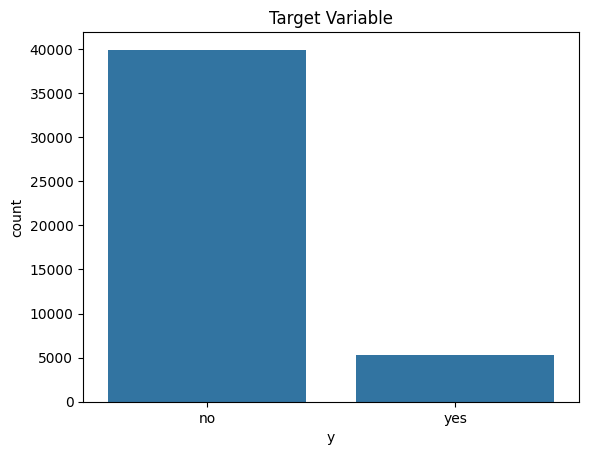

In [11]:
sns.countplot(x="y", data=df)
plt.title("Target Variable")
plt.show()

In [12]:
# percentage of class present in target variable(y)
print("percentage of NO and YES\n",df["y"].value_counts()/len(df)*100)

percentage of NO and YES
 y
no     88.30152
yes    11.69848
Name: count, dtype: float64


**The class distribution in the target variable is ~89:11 indicating an imbalance dataset**



**3.2 univariate analysis of categorical variables**

Index(['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome',
       'y'],
      dtype='object')


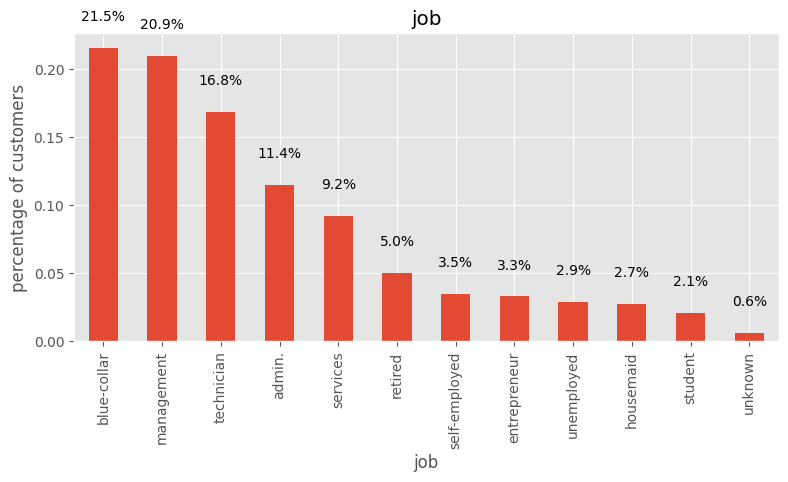

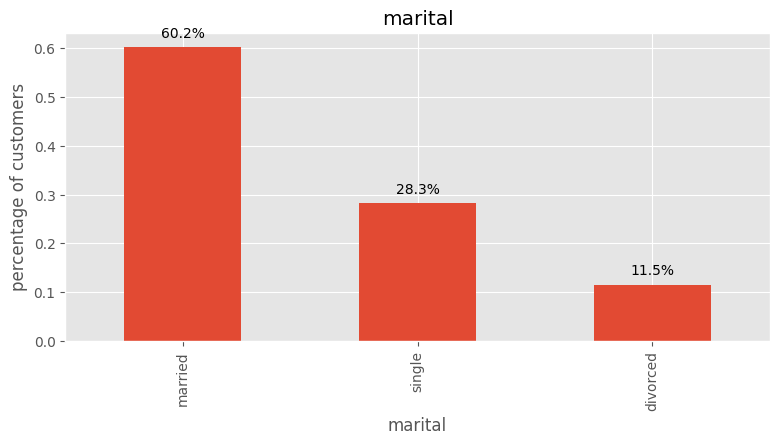

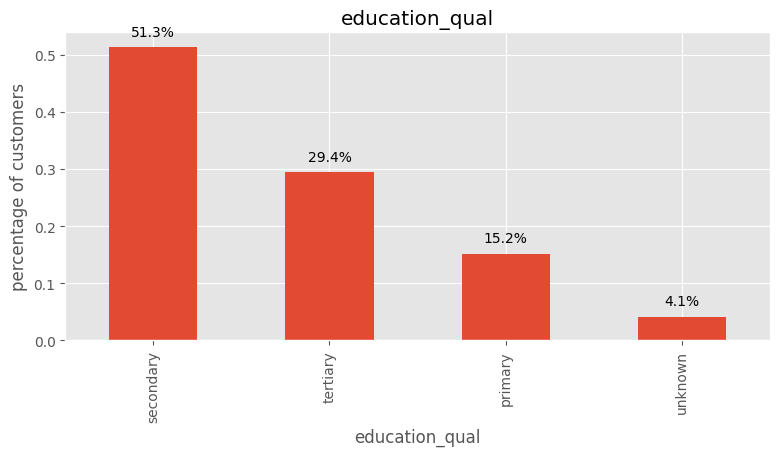

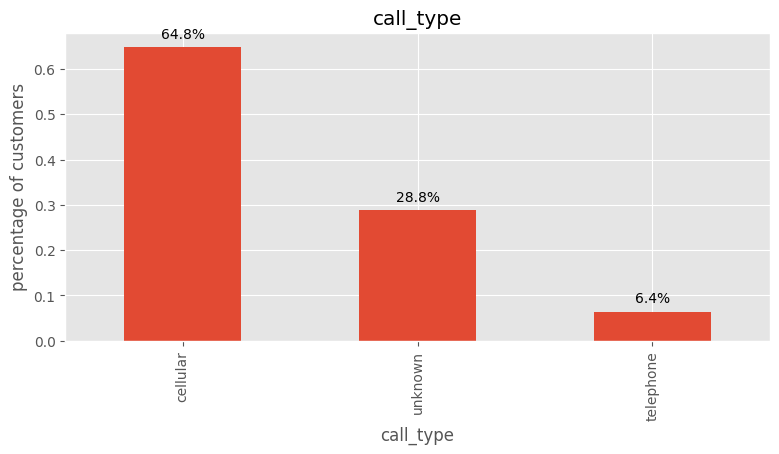

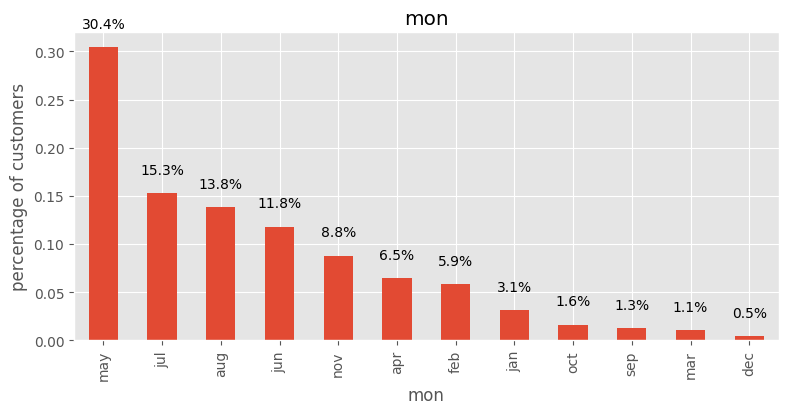

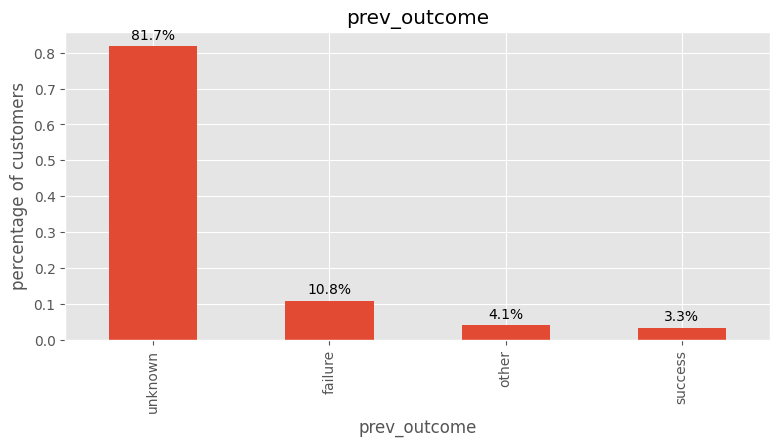

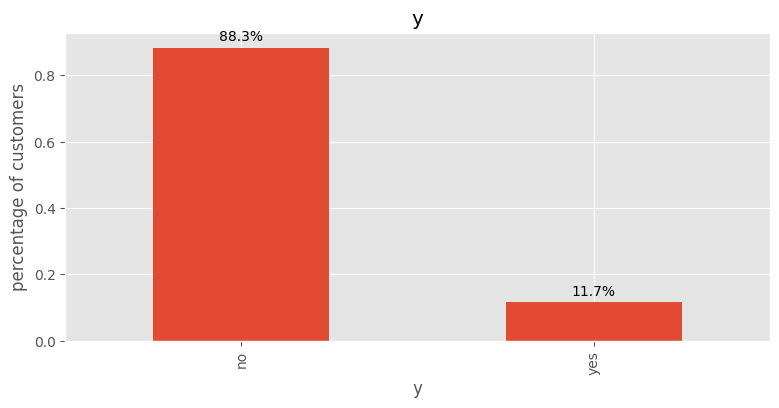

In [13]:
# indentifying the categorical variables
cat_var= df.select_dtypes(include= ["object"]).columns
print(cat_var)

# plotting bar chart for each categorical variable
plt.style.use("ggplot")

for column in cat_var:
    plt.figure(figsize=(20,4))
    ax = plt.subplot(121)
    df[column].value_counts(normalize=True).plot(kind="bar")
    plt.xlabel(column)
    plt.ylabel("percentage of customers")
    plt.title(column)

    # Add percentage labels to the top of each bar
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2., p.get_height()+0.02, f"{p.get_height()*100:.1f}%", ha="center")


**Observations :**

**The top three professions that our customers belong to are -Management , blue-collar jobs and technicians.**

**A huge number of the customers are married.**

**Cellular type is most used by customers.**

**Many customers have been contacted in the month of May.**

**Very less number of customers are there who succeessfully converted previously**

**Most of customers are belong to secondary education qualification**

**The plot for the target variable shows heavy imbalance in the target variable.**

**The missing values in some columns have been represented as unknown. unknown represents missing data.**



In [14]:
cate_var=['job','education_qual']
for column in cate_var:
    mode= df[column].mode()[0]
    df[column]= df[column].replace("unknown", mode)

**3.3 Univariate analysis of Numerical columns**

In [15]:
# indentifying the numerical variables
num_var= df.select_dtypes(include=np.number)
num_var.head()


,age,day,dur,num_calls
0,58,5,261,1
1,44,5,151,1
2,33,5,76,1
3,47,5,92,1
4,33,5,198,1


<ipython-input-16-c9f537584757>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)
<ipython-input-16-c9f537584757>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)
<ipython-input-16-c9f537584757>:6: UserWarning: 

`distplot` is a deprecated function and 

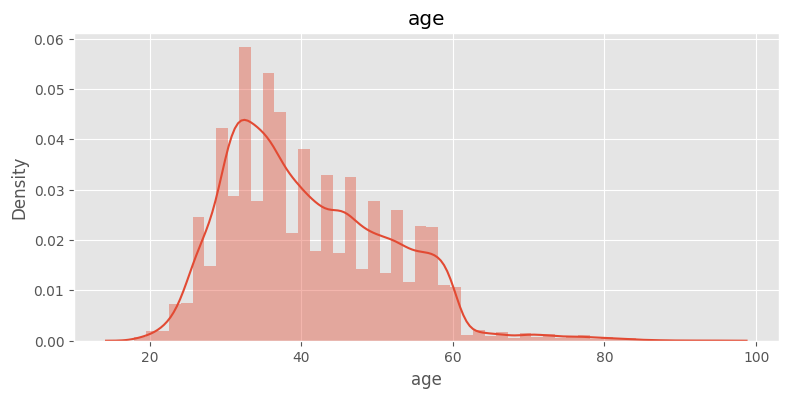

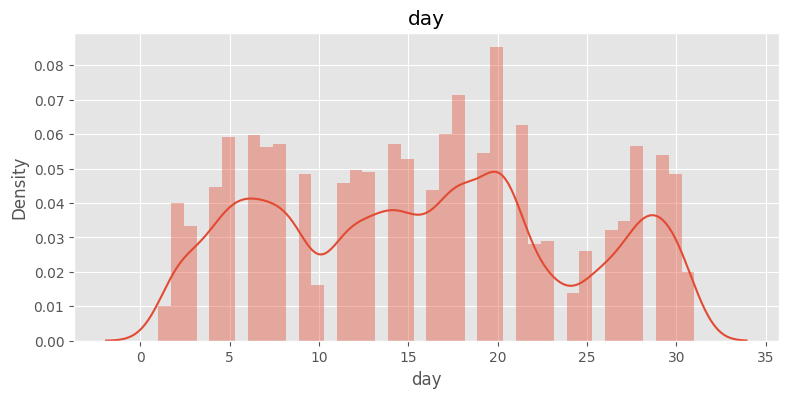

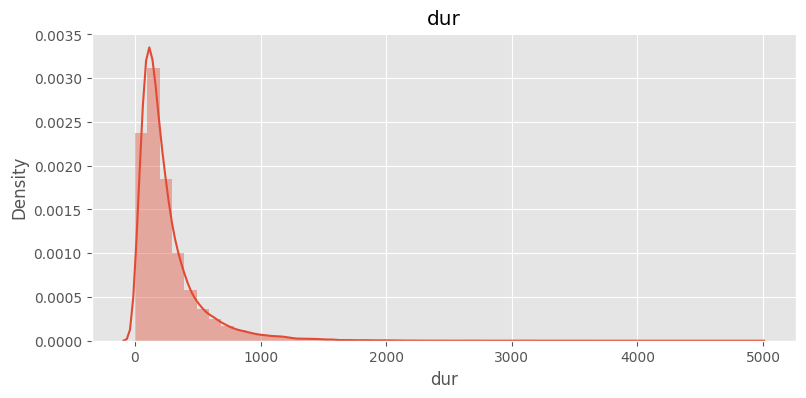

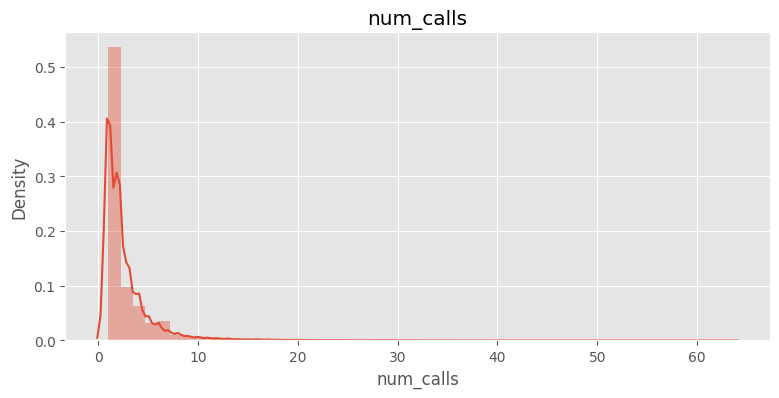

In [16]:
# plotting histogram for each numerical variable
plt.style.use("ggplot")
for column in ["age", "day", "dur",'num_calls']:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(df[column], kde=True)
    plt.title(column)

**Observation :**

**As we can see from the histogram, the features age, dur and num_calls are heavily skewed and this is due to the presence of outliers as seen in the boxplot for these features.**

**Looking at the plot for num_calls, we can infer that majority of the customers were being contacted for the first or second time time.**


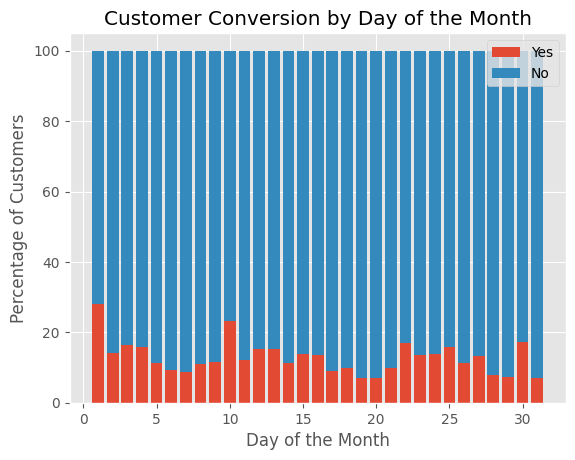

In [17]:
day_counts = df.groupby('day')['y'].value_counts(normalize=True) * 100
yes_counts = day_counts[:, 'yes']
no_counts = day_counts[:, 'no']

plt.bar(day_counts.index.levels[0], yes_counts, label='Yes')
plt.bar(day_counts.index.levels[0], no_counts, bottom=yes_counts, label='No')
plt.xlabel('Day of the Month')
plt.ylabel('Percentage of Customers')
plt.title('Customer Conversion by Day of the Month')
plt.legend()
plt.show()


 **Observation**

**from above plot we can see 1,10,30 dates are when customer said yes most**

**4.Bivariate Analysis of Categorical Columns**

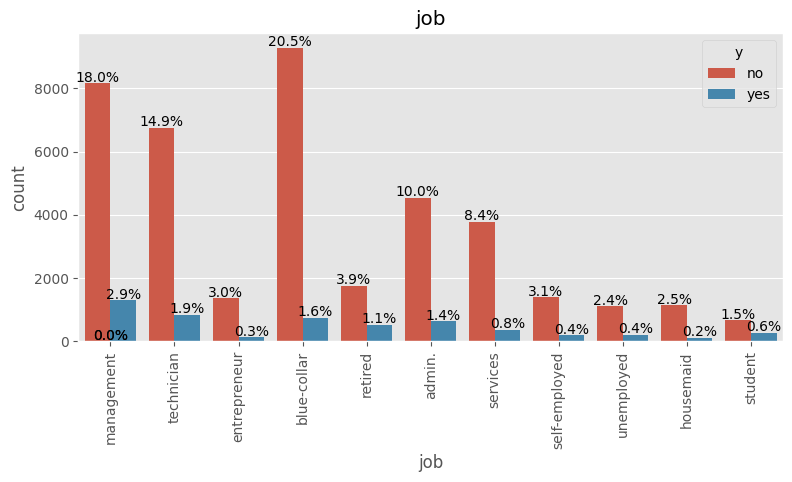

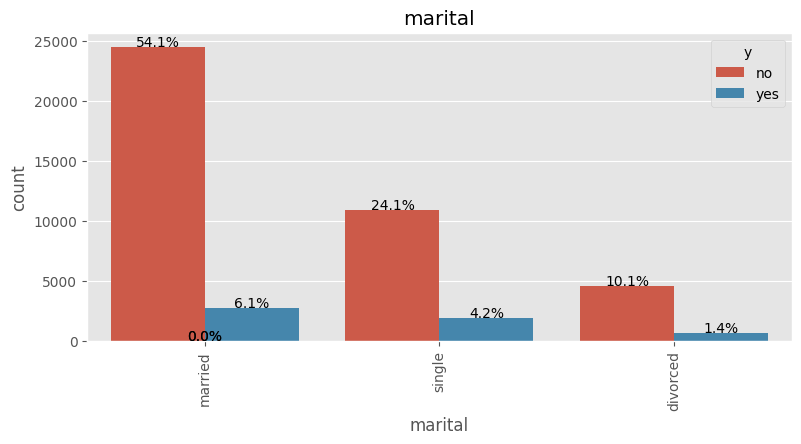

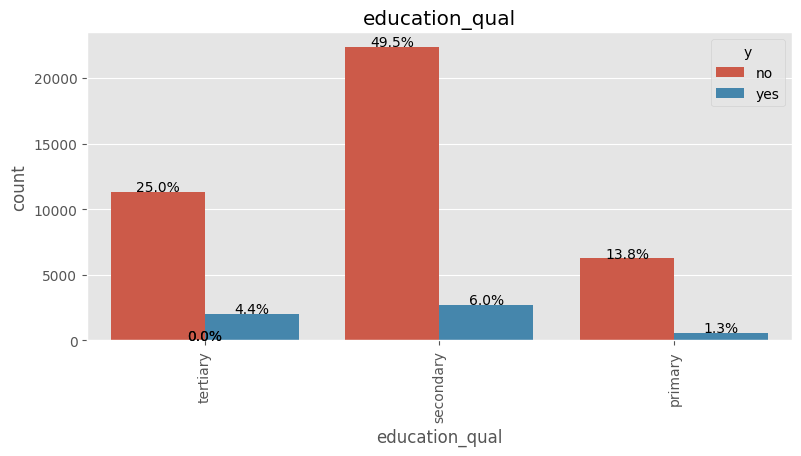

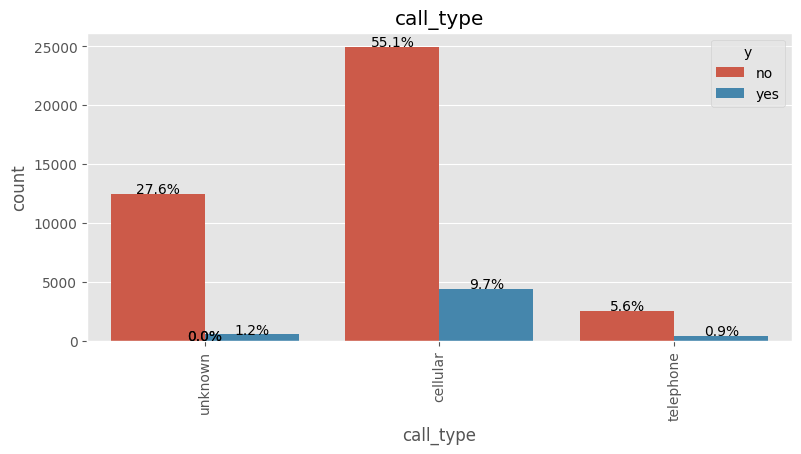

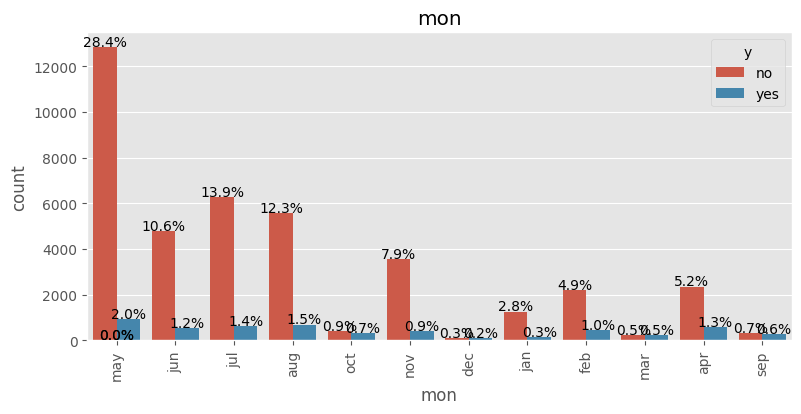

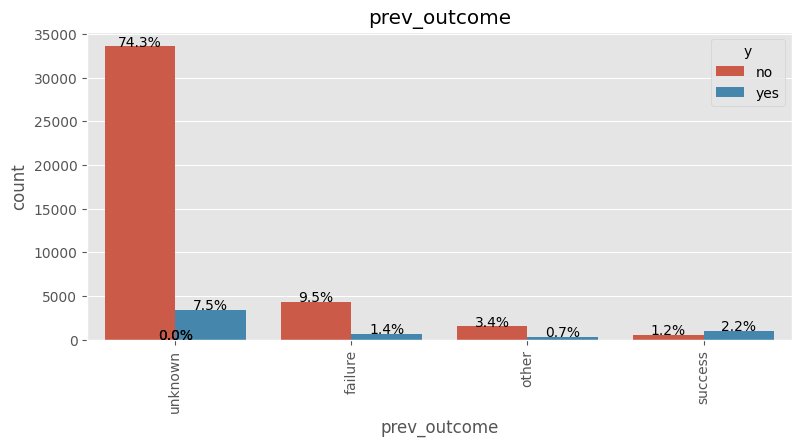

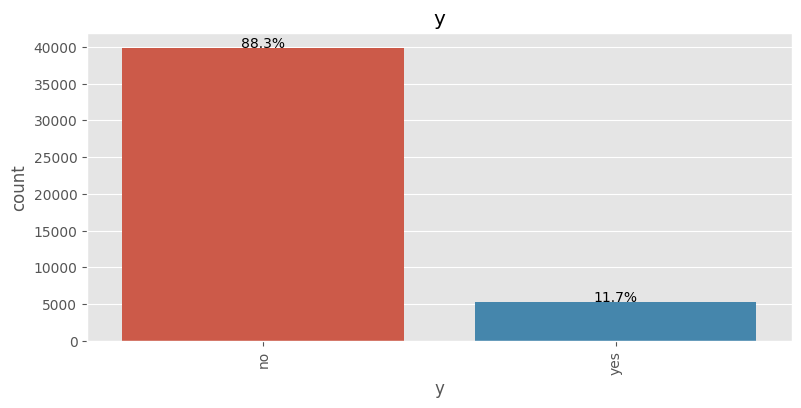

In [18]:
plt.style.use("ggplot")

for column in cat_var:
    plt.figure(figsize=(20,4))
    ax = plt.subplot(121)
    sns.countplot(x=column, hue="y", data=df)
    plt.title(column)
    plt.xticks(rotation=90)

    # Add percentage labels to the top of each bar
    for p in ax.patches:
        height = p.get_height()
        total = sum([p.get_height() for p in ax.patches if p.get_x() == p.get_x()])
        ax.text(p.get_x()+p.get_width()/2., height+50, f"{height/total*100:.1f}%", ha="center")

    plt.show()


**Observations:**

1.Customers having management jobs form the majority amongst those who have converted most.

2.married most of them converted

3.secondary education qualfied are converted most**

4.Cell-phones should be the preferred mode of contact for contacting customers.

5.may month should be the prefered month to contact

**5.Handling Outliers**


Outliers cause significant impact on the Mean and Variance.It becomes necessary to treat the outliers.

In [19]:
df.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


In [20]:
# compute interquantile range to calculate the boundaries
lower_boundries= []
upper_boundries= []
for i in ["age", "dur", "day","num_calls"]:
    IQR= df[i].quantile(0.75) - df[i].quantile(0.25)
    lower_bound= df[i].quantile(0.25) - (1.5*IQR)
    upper_bound= df[i].quantile(0.75) + (1.5*IQR)

    print(i, ":", lower_bound, ",",  upper_bound)

    lower_boundries.append(lower_bound)
    upper_boundries.append(upper_bound)

age : 10.5 , 70.5
dur : -221.0 , 643.0
day : -11.5 , 40.5
num_calls : -2.0 , 6.0


In [21]:
# replace the all the outliers which is greater then upper boundary by upper boundary
j = 0
for i in ["age", "dur", "day","num_calls"]:
    df.loc[df[i] > upper_boundries[j], i] = int(upper_boundries[j])
    j = j + 1

Since,

for age the lower boundary (10.5) < minimum value (18)
for dur num_calls and day the lower boundaries are negative (-221.0), (-11.0),(-2.0) resp.
replacing outliers with the lower boundary is not required

In [22]:
df.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.862799,15.806419,234.939307,2.392228
std,10.379659,8.322476,176.749932,1.600111
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,70.000000,31.000000,643.000000,6.000000


**After replacing the outliers with the upper boundary, the maximum values has been changed without impacting any other parameters like mean, standard deviation and quartiles.**

#**4.Encoding Categorical Features**

In [23]:
#'y'  target variable
df.replace({'y' : { 'yes' : 1, 'no' : 0}},inplace=True)


In [24]:
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), annot=True)

ValueError: could not convert string to float: 'married'

<Figure size 2500x1500 with 0 Axes>

In [25]:
cat_var= df.select_dtypes(include= ["object"]).columns
print(cat_var)

Index(['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome'], dtype='object')


In [26]:
for i in cat_var:
    print(i, ":", df[i].unique())

job : ['management' 'technician' 'entrepreneur' 'blue-collar' 'retired' 'admin.'
 'services' 'self-employed' 'unemployed' 'housemaid' 'student']
marital : ['married' 'single' 'divorced']
education_qual : ['tertiary' 'secondary' 'primary']
call_type : ['unknown' 'cellular' 'telephone']
mon : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
prev_outcome : ['unknown' 'failure' 'other' 'success']


In [27]:
def encoding_data(df,col):
  for i in col:
     df_dummies = pd.get_dummies(df[i], prefix=i)
     df = pd.concat([df, df_dummies], axis=1)
     df.drop([i],inplace=True,axis=1)
  return df

In [28]:
columns=['call_type','prev_outcome','marital','job']
df=encoding_data(df,columns)

In [29]:
#Months column
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df['mon'] = df['mon'].apply(
    lambda x: months.index(x)+1
)

In [30]:
#'education_qual'
df.replace({'education_qual' : { 'tertiary' : 1, 'secondary' : 2, 'primary' : 3 }},inplace=True)



**Oberservation**

As i have tried xgboost model,
When we label encode job we get auroc score **0.969** and when we use one hot encoding we get **0.986** so we are using **one hot encoding**

**Checking Correlation of feature variables**

**There are no features that are highly correlated and inversely correlated. If we had, we could have written the condition that if the correlation is higher than 0.8 (or can be any threshold value depending on the domain knowledge) and less than -0.8, we could have drop those features. Because those correlated features would have been doing the same job.**

#**5.Split Dataset**

**Separating independent and dependent variables**

In [31]:
p= df.drop(['y'],axis=1)
q= df['y']


**Since the class distribution in the target variable is ~89:11 indicating an imbalance dataset, we need to resample it**

**SMOTE Oversampling we are using due to imbalence data**

In [32]:

# Define the SMOTETomek object with a 0.75 sampling strategy
smote_tomek = SMOTETomek(sampling_strategy=0.75)

# Apply SMOTETomek oversampling to the training data
X, y = smote_tomek.fit_resample(p, q)

# Check the class distribution of the resampled data
print(y.value_counts())


y
0    39463
1    29482
Name: count, dtype: int64


**Splitting resampled data in train and test data**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#**6.Scalling**

**Scalling data**

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#**7.Models**

**1.Logistic Regression**

In [35]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)
predicted=lr_model.predict(X_test)
conf = confusion_matrix(y_test, predicted)

print()
print()
print ("The accuracy of Logistic Regression is : ", accuracy_score(y_test, predicted)*100, "%")
print ("The aurroc_auc_score of Logistic Regression is : ", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))
log_reg_y_pred_prob = lr_model.predict_proba(X_test)[:, 1]
log_reg_auc = roc_auc_score(y_test, log_reg_y_pred_prob)




The accuracy of Logistic Regression is :  92.12816455696202 %
The aurroc_auc_score of Logistic Regression is :  0.9747485170694768


**2.Random Forest**

In [36]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train, y_train)
predicted = rf_model.predict(X_test)
print("The accuracy of Random Forest is : ", accuracy_score(y_test, predicted.round())*100, "%")
print ("The aurroc_auc_score of  random forest is : ", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))
dt_y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_pred_prob)
dt_auc = roc_auc_score(y_test, dt_y_pred_prob)

The accuracy of Random Forest is :  93.51705344585092 %
The aurroc_auc_score of  random forest is :  0.9855893623398749


**3.XGBOOST**

In [37]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False)
xgb_model.fit(X_train, y_train)
predicted = xgb_model.predict(X_test)

print()
print ("The accuracy of X Gradient Boosting is : ", accuracy_score(y_test, predicted)*100, "%")
print ("The aurroc_auc_score of Gradient Boosting is : ", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))
xgb_y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_y_pred_prob)


The accuracy of X Gradient Boosting is :  93.49507735583686 %
The aurroc_auc_score of Gradient Boosting is :  0.9855808985927936


**observations**

With SMOTE oversampling we are getting high auroc score

Without smote auroc score for logistic regression,random forest and xgboost is 0.879 ,0.919 and 0.927


With smote auroc score for logistic regression,random forest and xgboost is 0.975,0.985 and 0.985

#**7.Feature Importance**

<Axes: >

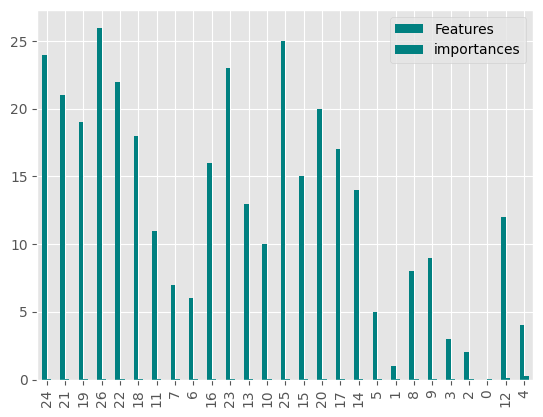

In [38]:
importances = rf_model.feature_importances_
df1 = pd.DataFrame({"Features":pd.DataFrame(X_test).columns,"importances":importances})
df1.set_index("importances")

df1 = df1.sort_values('importances')
df1.plot.bar(color='teal')

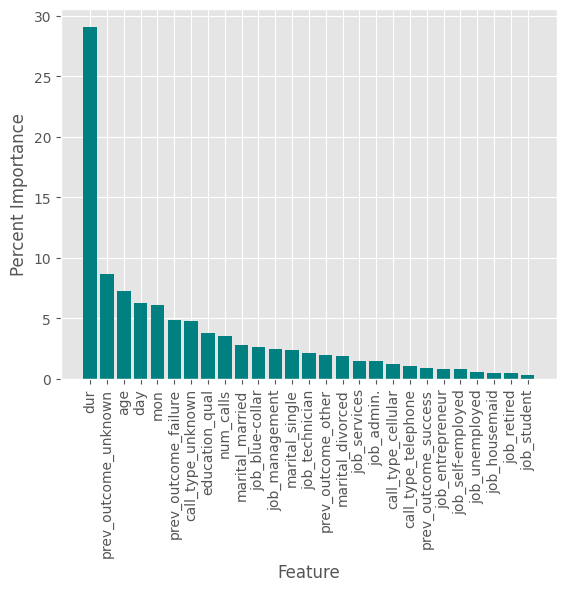

In [39]:
feature_names = list(df.columns)
if 'y' in feature_names:
    feature_names.remove('y')
total_importance = importances.sum()
percent_importances = importances / total_importance * 100

# Create a DataFrame with the feature names and their percent importances
df = pd.DataFrame({'feature_names': feature_names, 'percent_importances': percent_importances})

# Sort the DataFrame by percent importances in descending order
df = df.sort_values(by='percent_importances', ascending=False)

# Create a bar plot of the percent importances
plt.bar(x=df['feature_names'], height=df['percent_importances'], color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Percent Importance')
plt.show()

**Most important feature is duration**

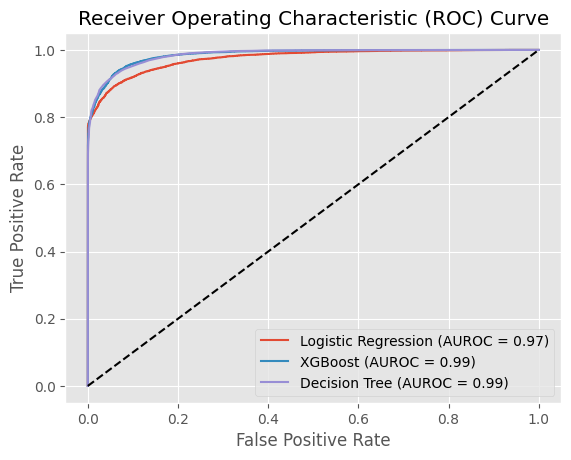

In [40]:
log_reg_fpr, log_reg_tpr, _ = roc_curve(y_test, log_reg_y_pred_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred_prob)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_y_pred_prob)

# Plot ROC curves
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUROC = {log_reg_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUROC = {xgb_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUROC = {dt_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


#**Conclusion**

**Based on the results obtained from the evaluation of the three classification models (Logistic Regression, XGBoost, and Decision Tree Classifier) on the given historical data, XGBoost outperformed the other models with the highest accuracy score of 93.54% and the highest AUROC score of 0.986.**

**This implies that XGBoost is a suitable model for predicting whether a client will subscribe to the insurance or not. It is recommended to deploy this model in the production environment to accurately target potential customers and optimize marketing costs.**

**However, further analysis is recommended to identify the important features contributing to the model's performance and to fine-tune the model for better results.**